In [1]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import ensemble
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn import linear_model
from sklearn import metrics
from sklearn.feature_selection import SelectKBest, f_regression
from scipy.stats import shapiro, normaltest

import warnings

warnings.filterwarnings('ignore')

## Подготовка данных

In [2]:
# Загрузка данных
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
# Вывод первых пяти строк тренировочного набора данных
train_df.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,...,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,...,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,...,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,...,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,...,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,...,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


## Информация о данных
1. id - идентификатор страхователя            
2. Age - Возраст страхователя
3. Gender - Пол страхователя
4. Annual Income - Годовой доход страхователя
5. Marital Status - Семейное положение страхователя
6. Number of Dependents - Количество иждивенцев страхователя
7. Education Level - Уровень образования страхователя
8. Occupation - Род занятий страхователя
9. Health Score - Оценка состояния здоровья страхователя
10. Location - Местоположение страхователя
11. Policy Type - Тип полиса страхователя
12. Previous Claims - Предыдущие претензии
13. Vehicle Age - Возраст транспортного средства страхователя
14. Credit Score - Кредитный рейтинг страхователя
15. Insurance Duration - Срок действия страховки
16. Policy Start Date - Дата начала полиса
17. Customer Feedback - Отзывы клиентов
18. Smoking Status - Статус курения страхователя
19. Exercise Frequency - Частота занятий спортом
20. Property Type - Тип недвижимости
21. Premium Amount - Сумма страховой премии

In [4]:
# Функция для отображения пропусков в данных в процентном выражении
def search_null(data):
    columns_null_pr = data.isnull().mean()*100
    columns_with_null = columns_null_pr[columns_null_pr > 0].sort_values(ascending = False)
    return columns_with_null

In [5]:
# Применение указанной выше функции к тренировочному набору данных
train_null = search_null(train_df)
train_null

Previous Claims         30.335750
Occupation              29.839583
Credit Score            11.490167
Number of Dependents     9.139333
Customer Feedback        6.485333
Health Score             6.173000
Annual Income            3.745750
Age                      1.558750
Marital Status           1.544083
Vehicle Age              0.000500
Insurance Duration       0.000083
dtype: float64

In [6]:
# Применение указанной выше функции к тестовому набору данных
test_null = search_null(test_df)
test_null

Previous Claims         30.350250
Occupation              29.890625
Credit Score            11.431375
Number of Dependents     9.141250
Customer Feedback        6.534500
Health Score             6.181125
Annual Income            3.732500
Age                      1.561125
Marital Status           1.542000
Vehicle Age              0.000375
Insurance Duration       0.000250
dtype: float64

In [7]:
# Проверка на равенство количества пропусков в тренировочной и тестовой выборках
train_null == test_null

Previous Claims         False
Occupation              False
Credit Score            False
Number of Dependents    False
Customer Feedback       False
Health Score            False
Annual Income           False
Age                     False
Marital Status          False
Vehicle Age             False
Insurance Duration      False
dtype: bool

In [8]:
# Функция для заполнения пропусков
def null_out(data, train_null):
    numerical_cols = data.select_dtypes(include=['number']).columns.tolist()
    categorical_cols = data.select_dtypes(exclude=['number']).columns.tolist()
    column_names_train = train_null.index.tolist()
    for name in numerical_cols:
        if name in column_names_train:
            # Для числовых признаков - заполнение медианным значением
            data[name] = data[name].fillna(data[name].median())
    for name in categorical_cols:
        if name in column_names_train:
            # Для категориальных признаков - заполнение модальным значением
            data[name] = data[name].fillna(data[name].mode()[0])
    return data

In [9]:
# Применение указанной выше функции к тренировочному набору данных
train_df = null_out(train_df, train_null)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1200000 non-null  int64  
 1   Age                   1200000 non-null  float64
 2   Gender                1200000 non-null  object 
 3   Annual Income         1200000 non-null  float64
 4   Marital Status        1200000 non-null  object 
 5   Number of Dependents  1200000 non-null  float64
 6   Education Level       1200000 non-null  object 
 7   Occupation            1200000 non-null  object 
 8   Health Score          1200000 non-null  float64
 9   Location              1200000 non-null  object 
 10  Policy Type           1200000 non-null  object 
 11  Previous Claims       1200000 non-null  float64
 12  Vehicle Age           1200000 non-null  float64
 13  Credit Score          1200000 non-null  float64
 14  Insurance Duration    1200000 non-

In [10]:
# Применение указанной выше функции к тестовому набору данных
test_df = null_out(test_df, train_null)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    800000 non-null  int64  
 1   Age                   800000 non-null  float64
 2   Gender                800000 non-null  object 
 3   Annual Income         800000 non-null  float64
 4   Marital Status        800000 non-null  object 
 5   Number of Dependents  800000 non-null  float64
 6   Education Level       800000 non-null  object 
 7   Occupation            800000 non-null  object 
 8   Health Score          800000 non-null  float64
 9   Location              800000 non-null  object 
 10  Policy Type           800000 non-null  object 
 11  Previous Claims       800000 non-null  float64
 12  Vehicle Age           800000 non-null  float64
 13  Credit Score          800000 non-null  float64
 14  Insurance Duration    800000 non-null  float64
 15  

## Feature Engineering

In [11]:
# Функция для преобразования признака времени 
def get_drop_and_date_features(data):
    data.columns = data.columns.str.replace(" ", "_")
    data = data.drop('id', axis = 1)
    data['Policy_Start_Date'] = pd.to_datetime(data['Policy_Start_Date'])
    data['Year'] = data['Policy_Start_Date'].dt.year.astype('category')
    data['Month'] = data['Policy_Start_Date'].dt.month.astype('category')
    data['Day'] = data['Policy_Start_Date'].dt.day.astype('category')
    data['Month_name'] = data['Policy_Start_Date'].dt.month_name()
    data['Day_of_week'] = data['Policy_Start_Date'].dt.day_name()
    data['Policy_Start_Date'] = data['Policy_Start_Date'].dt.date
    return data

# Функция для создания новых признаков 
def get_new_features(data):
    data['Annual_Income_Health_Score_Ratio'] = data['Health_Score'] / data['Annual_Income'] # Соотношение годового дохода к оценке состояния здоровья
    data['Annual_Income_Age_Ratio'] = data['Annual_Income'] / data['Age'] # Соотношение годового дохода к возрасту
    data['Credit_Age'] = data['Credit_Score'] / data['Age'] # Кредитных возраст
    data['Vehicle_Age_Insurance_Duration'] = data['Vehicle_Age'] / data['Insurance_Duration'] # Срок страхования по отношению к возрасту транспортного средства
    return data

In [12]:
# Применение указанной выше функции к тренировочному и тестовому набору данных 
train_df = get_drop_and_date_features(train_df)
test_df = get_drop_and_date_features(test_df)

train_df = get_new_features(train_df)
test_df = get_new_features(test_df)

In [13]:
# Описательная статистика числовых признаков тренировочного набора данных 
train_df.describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
Age,1200000.0,41.14,13.43,18.00,30.00,41.00,53.00,64.00
Annual_Income,1200000.0,32414.31,31615.60,1.00,8646.00,23911.00,43936.00,149997.00
Number_of_Dependents,1200000.0,2.01,1.35,0.00,1.00,2.00,3.00,4.00
Health_Score,1200000.0,25.55,11.82,2.01,16.55,24.58,33.77,58.98
Previous_Claims,1200000.0,1.00,0.82,0.00,0.00,1.00,1.00,9.00
Vehicle_Age,1200000.0,9.57,5.78,0.00,5.00,10.00,15.00,19.00
Credit_Score,1200000.0,593.16,141.10,300.00,484.00,595.00,706.00,849.00
Insurance_Duration,1200000.0,5.02,2.59,1.00,3.00,5.00,7.00,9.00
Premium_Amount,1200000.0,1102.54,865.00,20.00,514.00,872.00,1509.00,4999.00
Annual_Income_Health_Score_Ratio,1200000.0,0.01,0.08,0.00,0.00,0.00,0.00,34.24


In [14]:
# Описательная статистика числовых признаков тестового набора данных 
test_df.describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
Age,800000.0,41.13,13.43,18.00,30.00,41.00,53.00,64.00
Annual_Income,800000.0,32474.56,31638.63,2.00,8689.00,23981.00,43944.25,149997.00
Number_of_Dependents,800000.0,2.01,1.35,0.00,1.00,2.00,3.00,4.00
Health_Score,800000.0,25.55,11.83,1.65,16.56,24.58,33.77,57.96
Previous_Claims,800000.0,1.00,0.82,0.00,0.00,1.00,1.00,9.00
Vehicle_Age,800000.0,9.57,5.77,0.00,5.00,10.00,15.00,19.00
Credit_Score,800000.0,593.14,141.28,300.00,483.00,595.00,706.00,849.00
Insurance_Duration,800000.0,5.02,2.59,1.00,3.00,5.00,7.00,9.00
Annual_Income_Health_Score_Ratio,800000.0,0.01,0.07,0.00,0.00,0.00,0.00,21.61
Annual_Income_Age_Ratio,800000.0,896.02,996.94,0.04,219.75,584.55,1184.30,8331.89


In [15]:
# Вывод числовых и категориальных признаков тренировочного набора данных
numerical_cols_train = train_df.select_dtypes(include=['number']).columns.tolist()
categorical_cols_train = train_df.select_dtypes(exclude=['number']).columns.tolist()

print(f'Number columns: {numerical_cols_train}\nCategorical columns: {categorical_cols_train}')

Number columns: ['Age', 'Annual_Income', 'Number_of_Dependents', 'Health_Score', 'Previous_Claims', 'Vehicle_Age', 'Credit_Score', 'Insurance_Duration', 'Premium_Amount', 'Annual_Income_Health_Score_Ratio', 'Annual_Income_Age_Ratio', 'Credit_Age', 'Vehicle_Age_Insurance_Duration']
Categorical columns: ['Gender', 'Marital_Status', 'Education_Level', 'Occupation', 'Location', 'Policy_Type', 'Policy_Start_Date', 'Customer_Feedback', 'Smoking_Status', 'Exercise_Frequency', 'Property_Type', 'Year', 'Month', 'Day', 'Month_name', 'Day_of_week']


Distribution of features in the training sample


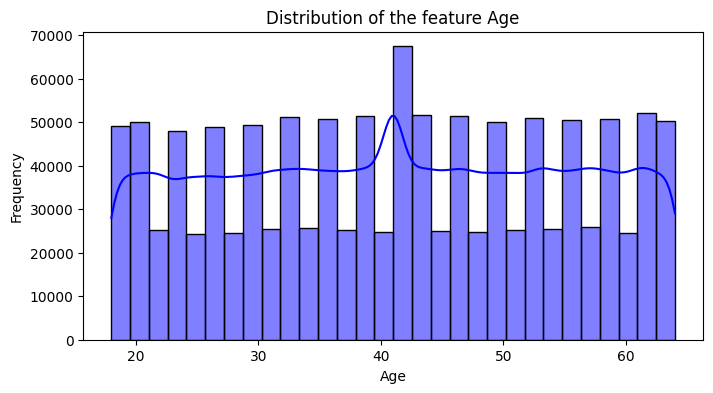

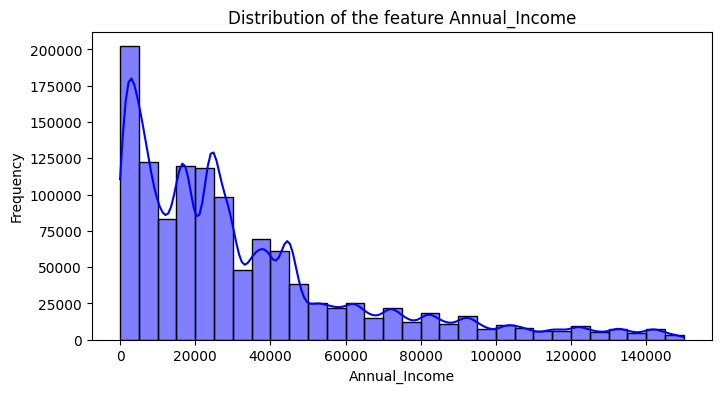

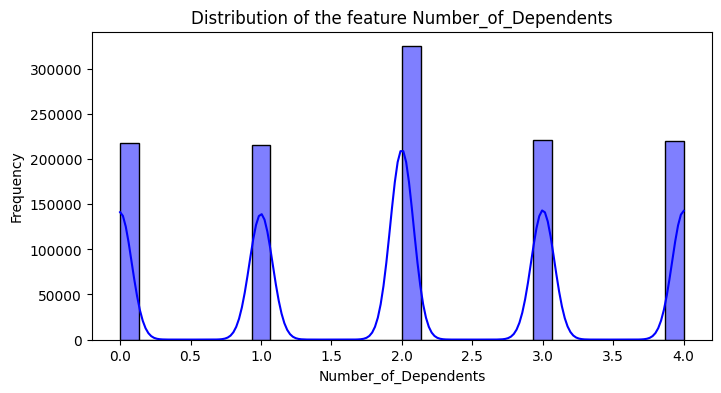

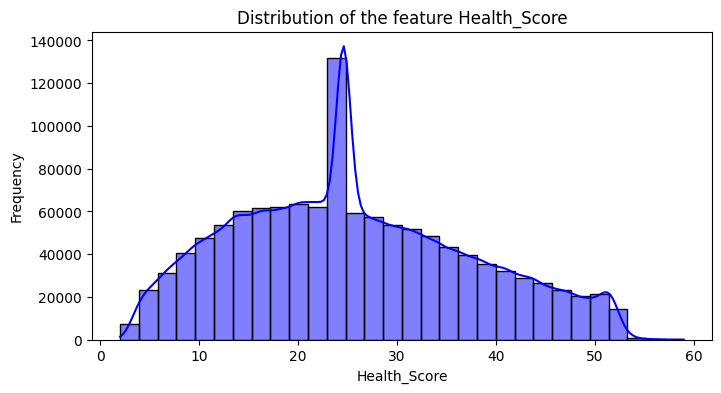

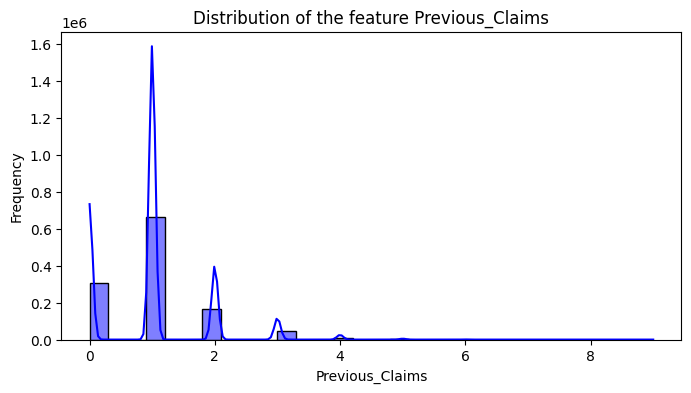

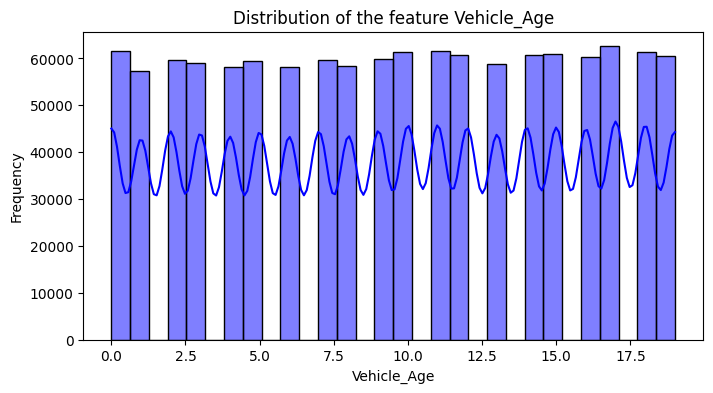

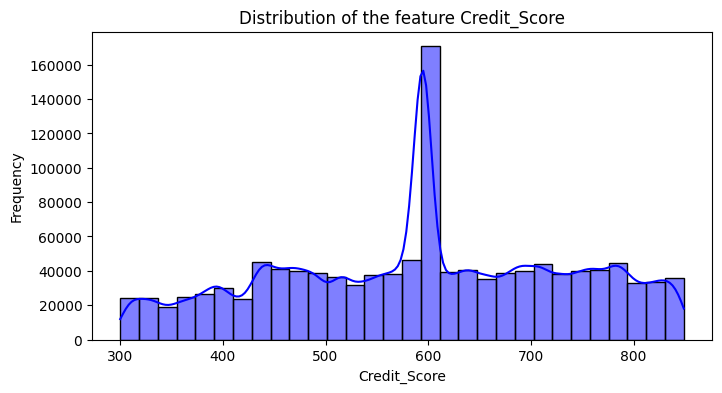

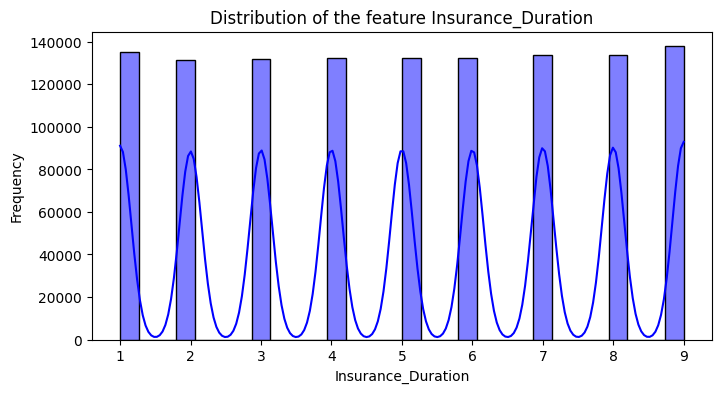

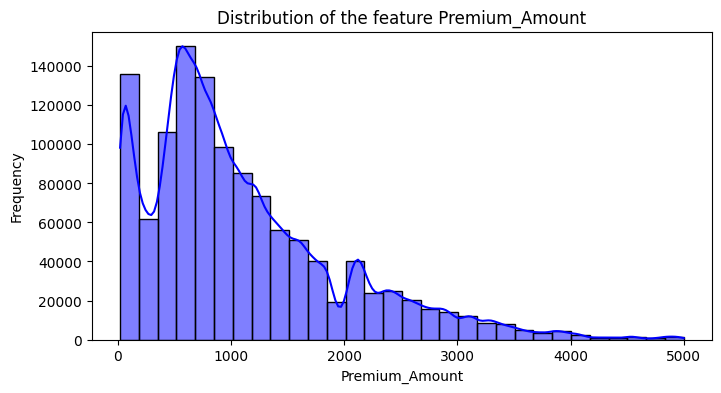

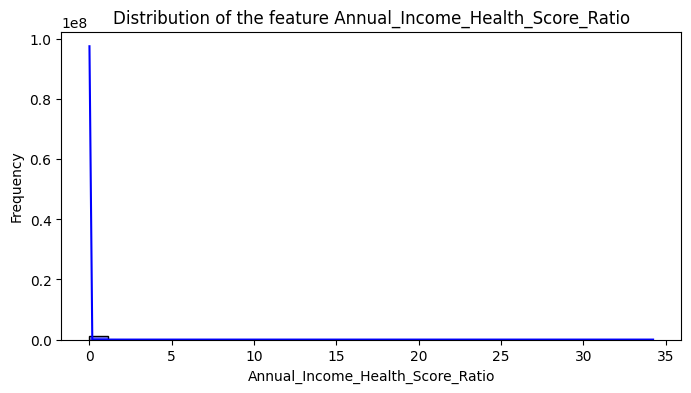

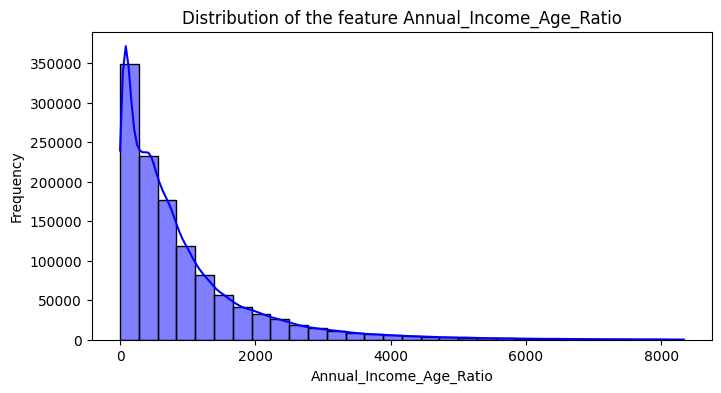

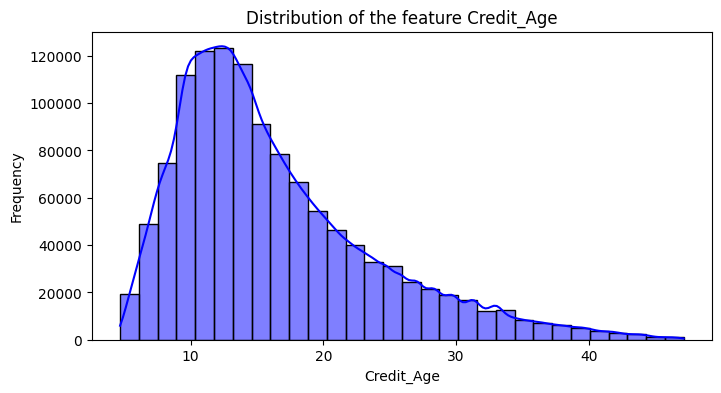

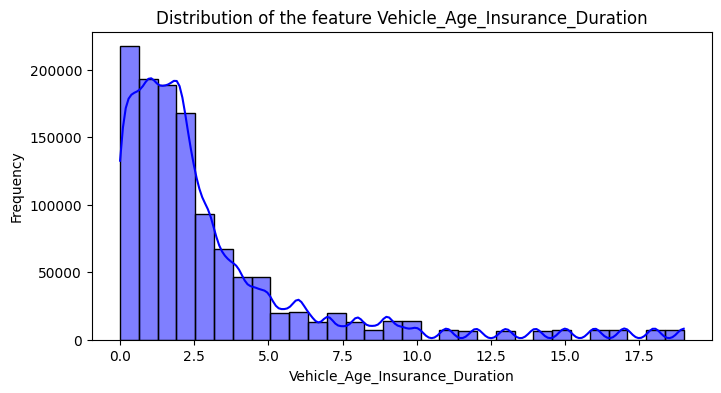

In [16]:
# Распределение числовых признаков в тренировочном наборе данных
print('Distribution of features in the training sample')
for col in numerical_cols_train:
    plt.figure(figsize=(8, 4))
    sns.histplot(train_df[col], kde=True, bins=30, color='blue')
    plt.title(f'Distribution of the feature {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show() 

In [17]:
# Проведение теста Шапиро-Уилка для определения распределения числовых признаков в тренировочном наборе данных
for col in numerical_cols_train:
    stat, p_value = shapiro(train_df[col].dropna())
    print(f'Shapiro-Wilk test for {col}: p-value = {p_value}')
    if p_value < 0.05:
        print(f'The {col} feature is not normal (reject H0)')
    else:
        print(f'The {col} feature may be normal (we do not reject H0)')

Shapiro-Wilk test for Age: p-value = 0.0
The Age feature is not normal (reject H0)
Shapiro-Wilk test for Annual_Income: p-value = 0.0
The Annual_Income feature is not normal (reject H0)
Shapiro-Wilk test for Number_of_Dependents: p-value = 0.0
The Number_of_Dependents feature is not normal (reject H0)
Shapiro-Wilk test for Health_Score: p-value = 0.0
The Health_Score feature is not normal (reject H0)
Shapiro-Wilk test for Previous_Claims: p-value = 0.0
The Previous_Claims feature is not normal (reject H0)
Shapiro-Wilk test for Vehicle_Age: p-value = 0.0
The Vehicle_Age feature is not normal (reject H0)
Shapiro-Wilk test for Credit_Score: p-value = 0.0
The Credit_Score feature is not normal (reject H0)
Shapiro-Wilk test for Insurance_Duration: p-value = 0.0
The Insurance_Duration feature is not normal (reject H0)
Shapiro-Wilk test for Premium_Amount: p-value = 0.0
The Premium_Amount feature is not normal (reject H0)
Shapiro-Wilk test for Annual_Income_Health_Score_Ratio: p-value = 0.0
T

Поскольку данные числовых признаков, в том числе целевой признак "Сумма страховой премии" распределен не нормально, логорифмируем целевой признак  

In [18]:
# Логарифмирование целевого признака
train_df['Premium_Amount_Log'] = np.log(train_df['Premium_Amount']+1)

## EDA

P-value: 0.00
The distribution is not normal


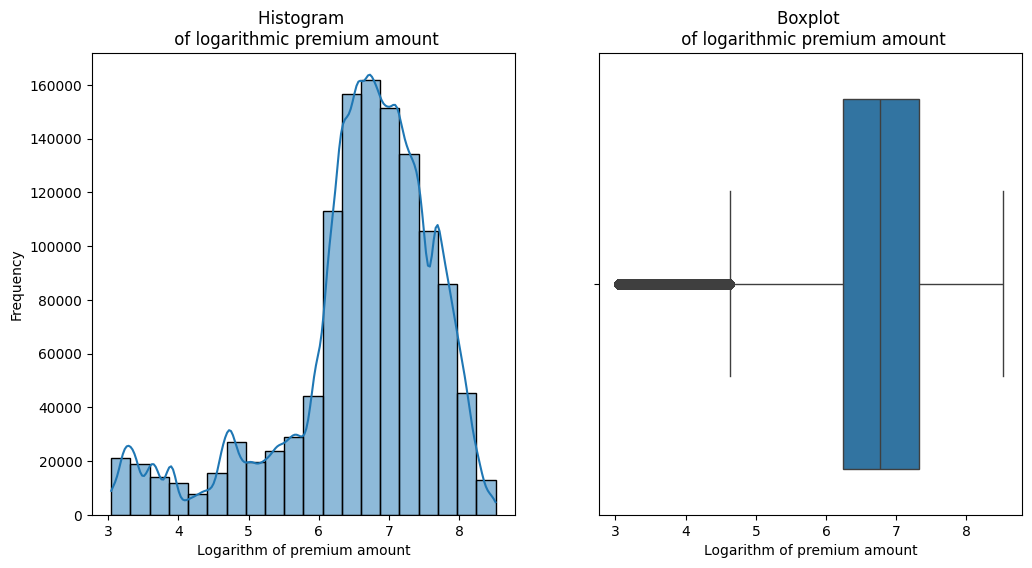

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Гистограмма распределения целевого признака в логарифмическом масштабе
sns.histplot(train_df['Premium_Amount_Log'], bins=20, kde=True, ax=ax[0])
ax[0].set_title('Histogram \n of logarithmic premium amount')
ax[0].set_xlabel('Logarithm of premium amount')
ax[0].set_ylabel('Frequency')

# Коробчатая диаграмма распределения целевого признака в логарифмическом масштабе
sns.boxplot(train_df['Premium_Amount_Log'],orient='h', ax=ax[1])
ax[1].set_title('Boxplot \n of logarithmic premium amount')
ax[1].set_xlabel('Logarithm of premium amount');

# Проверка распределения логарифмированного целевого признака с использованием теста Д’Агостино
stat, p_value = normaltest(train_df['Premium_Amount_Log'])

print(f'P-value: {p_value:.2f}')

alpha = 0.05
if p_value < alpha:
    print('The distribution is not normal')
else:
    print('The distribution is normal')

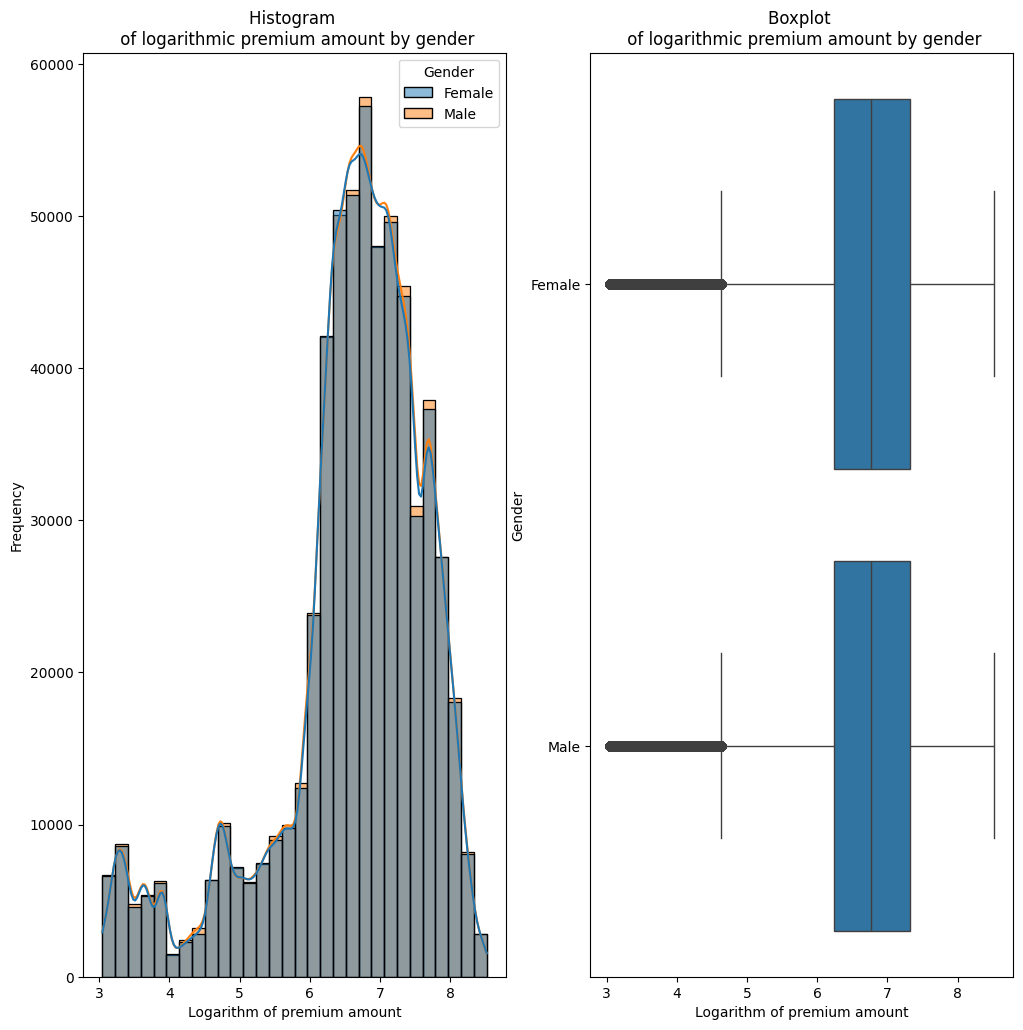

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12, 12))

# Гистограмма распределения целевого признака в логарифмическом масштабе относительно пола страхователя 
sns.histplot(data=train_df, x='Premium_Amount_Log', hue='Gender', bins=30, kde=True, ax=ax[0])
ax[0].set_title('Histogram \n of logarithmic premium amount by gender')
ax[0].set_xlabel('Logarithm of premium amount')
ax[0].set_ylabel('Frequency')

# Коробчатая диаграмма распределения целевого признака в логарифмическом масштабе относительно пола страхователя 
sns.boxplot(data=train_df, x='Premium_Amount_Log', y='Gender', orient='h', ax=ax[1])
ax[1].set_title('Boxplot \n of logarithmic premium amount by gender')
ax[1].set_ylabel('Gender')
ax[1].set_xlabel('Logarithm of premium amount');

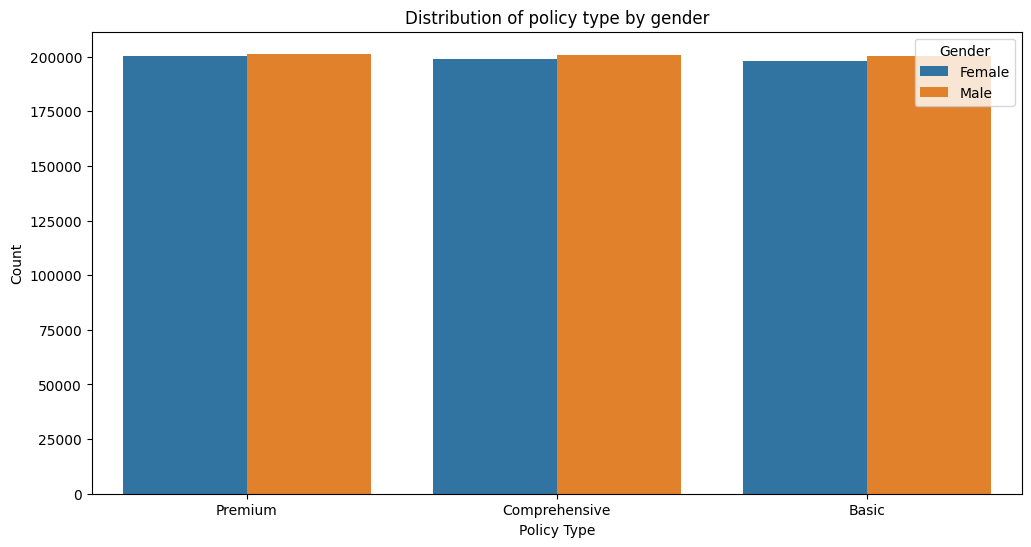

In [21]:
# Тип полиса относительно пола страхователя
plt.figure(figsize=(12, 6))
sns.countplot(train_df, x='Policy_Type', hue='Gender')
plt.title('Distribution of policy type by gender')
plt.xlabel('Policy Type')
plt.ylabel('Count')
plt.legend(title='Gender')
plt.show();

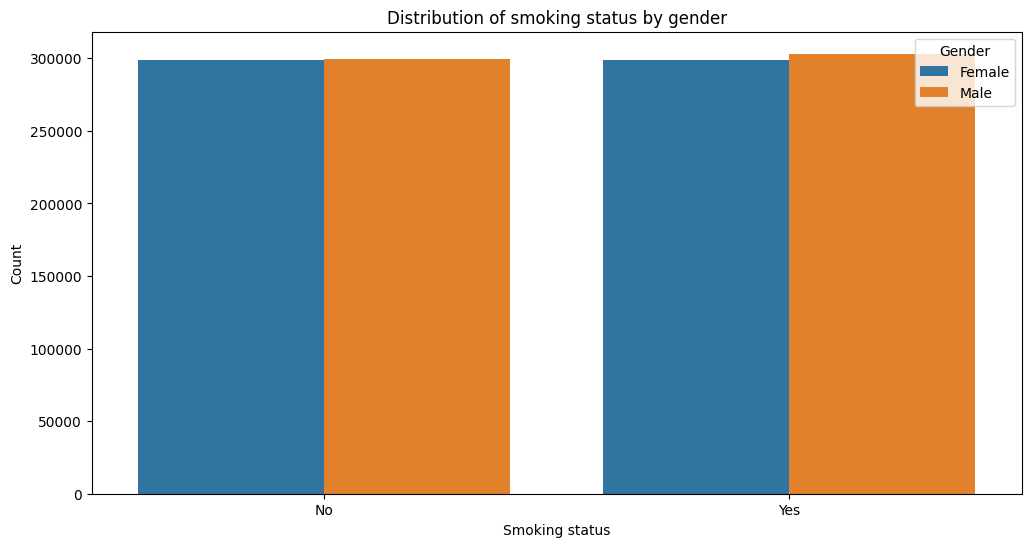

In [22]:
# Зависимость курения от пола страхователя
plt.figure(figsize=(12, 6))
sns.countplot(train_df, x='Smoking_Status', hue='Gender')
plt.title('Distribution of smoking status by gender')
plt.xlabel('Smoking status')
plt.ylabel('Count')
plt.legend(title='Gender')
plt.show();

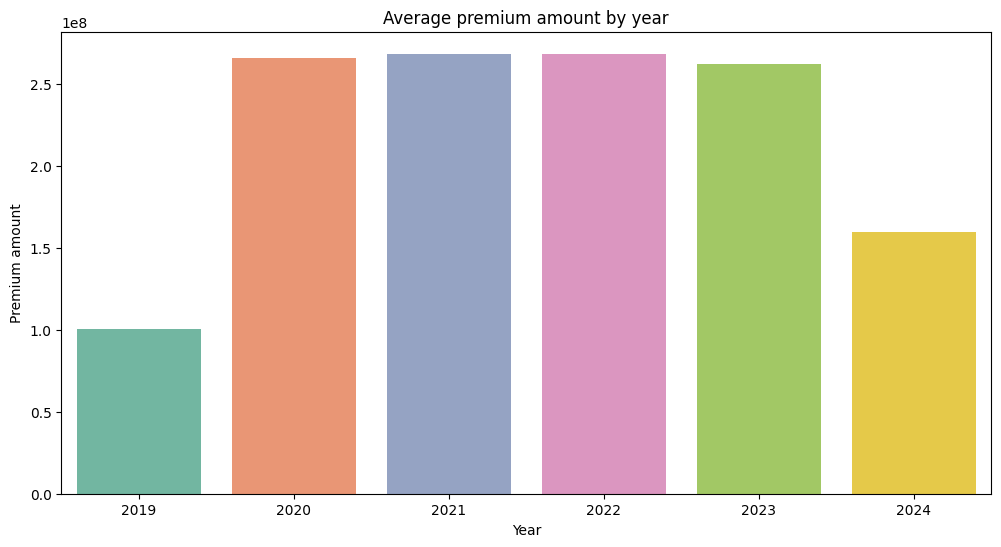

In [23]:
year_group = train_df.groupby('Year')['Premium_Amount'].sum().reset_index()

# Средний размер страховой премии в зависимости от года
plt.figure(figsize=(12, 6))
sns.barplot(year_group, x='Year', y='Premium_Amount', ci=None, palette='Set2')
plt.title('Average premium amount by year')
plt.xlabel('Year')
plt.ylabel('Premium amount')
plt.show();

In [24]:
# Функция для преобразования признаков времени в числовой формат
def date_transform(data):
    data.drop('Policy_Start_Date', axis = 1, inplace = True)
    data['Year'] = data['Year'].astype(int) 
    data['Month'] = data['Month'].astype(int) 
    data['Day'] = data['Day'].astype(int)
    return data    

In [25]:
# Применение указанной выше функции к тренировочному и тестовому набору данных
train_df = date_transform(train_df)
test_df = date_transform(test_df)

In [26]:
# Выявление выбросов в числовых признаках в тренировочном наборе данных
outliers_indices = set()
for col in numerical_cols_train:
    Q1 = train_df[col].quantile(0.25)
    Q3 = train_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = train_df[(train_df[col] < lower_bound) | (train_df[col] > upper_bound)]
    
    print(f'Feature {col} - count of outliers: {len(outliers)}')
    
    outliers_indices.update(outliers.index)

Feature Age - count of outliers: 0
Feature Annual_Income - count of outliers: 70466
Feature Number_of_Dependents - count of outliers: 0
Feature Health_Score - count of outliers: 0
Feature Previous_Claims - count of outliers: 62066
Feature Vehicle_Age - count of outliers: 0
Feature Credit_Score - count of outliers: 0
Feature Insurance_Duration - count of outliers: 0
Feature Premium_Amount - count of outliers: 49320
Feature Annual_Income_Health_Score_Ratio - count of outliers: 170793
Feature Annual_Income_Age_Ratio - count of outliers: 76159
Feature Credit_Age - count of outliers: 41118
Feature Vehicle_Age_Insurance_Duration - count of outliers: 114868


In [27]:
# Удаление выбросов из тренировочного набора данных
train_df = train_df.drop(index=outliers_indices)
train_df.reset_index(drop=True, inplace=True)

print(f"DataFrame shape after removing outliers: {train_df.shape}")

DataFrame shape after removing outliers: (743700, 29)


In [28]:
# Вывод категориальных признаков тренировочного и тестового наборов данных
categorical_cols_train = train_df.select_dtypes(exclude=['number']).columns.tolist()
categorical_cols_test = test_df.select_dtypes(exclude=['number']).columns.tolist()
print(f'Categorical columns train: {categorical_cols_train}')
print('*' * 150)
print(f'Categorical columns test: {categorical_cols_test}')

Categorical columns train: ['Gender', 'Marital_Status', 'Education_Level', 'Occupation', 'Location', 'Policy_Type', 'Customer_Feedback', 'Smoking_Status', 'Exercise_Frequency', 'Property_Type', 'Month_name', 'Day_of_week']
******************************************************************************************************************************************************
Categorical columns test: ['Gender', 'Marital_Status', 'Education_Level', 'Occupation', 'Location', 'Policy_Type', 'Customer_Feedback', 'Smoking_Status', 'Exercise_Frequency', 'Property_Type', 'Month_name', 'Day_of_week']


In [29]:
# Функция для кодирования категориальных признаков
def encode_categorical_data(data):
    one_hot_columns = ['Marital_Status', 'Occupation', 'Location', 'Policy_Type', 'Property_Type',]
    label_columns = ['Gender', 'Education_Level', 'Smoking_Status', 'Exercise_Frequency', 'Customer_Feedback', 'Month_name', 'Day_of_week']
    data_one_hot = pd.get_dummies(data[one_hot_columns])
    label_encoder = LabelEncoder()
    for col in label_columns:
        data[col] = label_encoder.fit_transform(data[col])
    data_encoded = pd.concat([data.drop(columns=one_hot_columns), data_one_hot], axis=1)
    return data_encoded

In [30]:
# Применение указанной выше функции к тренировочному и тестовому набору данных
train_df = encode_categorical_data(train_df)
test_df = encode_categorical_data(test_df)

In [31]:
# Вывод размерности тренировочной выборки после преобразования категориальных признаков 
train_df.shape

(743700, 39)

In [32]:
# Разделение тренировочного набора данных на матрицу наблюдений и вектор правильных ответов 
X = train_df.drop(['Premium_Amount', 'Premium_Amount_Log'], axis=1)
y = train_df['Premium_Amount']
y_log = train_df['Premium_Amount_Log']

In [33]:
# Разделение данных на обучающую и валидационную выборки 
X_train, X_valid, y_train_log, y_valid_log = train_test_split(
    X, y_log, 
    test_size=0.30, 
    random_state=42
)

In [34]:
# Выявление лучших 20 признаков тренировочного набора данных для обучения модели
selector = SelectKBest(f_regression, k=20)
selector.fit(X_train, y_train_log)
selector.get_feature_names_out()

array(['Age', 'Annual_Income', 'Health_Score', 'Previous_Claims',
       'Credit_Score', 'Insurance_Duration', 'Customer_Feedback', 'Year',
       'Month', 'Day_of_week', 'Annual_Income_Health_Score_Ratio',
       'Annual_Income_Age_Ratio', 'Credit_Age',
       'Vehicle_Age_Insurance_Duration', 'Marital_Status_Divorced',
       'Marital_Status_Single', 'Location_Rural', 'Location_Urban',
       'Property_Type_Condo', 'Property_Type_House'], dtype=object)

In [35]:
# Разделение данных на обучающую и валидационную выборки с учетом лучших признаков
X = train_df[['Age', 'Annual_Income', 'Health_Score', 'Previous_Claims',
       'Credit_Score', 'Insurance_Duration', 'Customer_Feedback', 'Year',
       'Month', 'Day_of_week', 'Annual_Income_Health_Score_Ratio',
       'Annual_Income_Age_Ratio', 'Credit_Age',
       'Vehicle_Age_Insurance_Duration', 'Marital_Status_Divorced',
       'Marital_Status_Single', 'Location_Rural', 'Location_Urban',
       'Property_Type_Condo', 'Property_Type_House']]
X_train, X_valid, y_train_log, y_valid_log = train_test_split(
    X, y_log, 
    test_size=0.30, 
    random_state=42
)

In [36]:
# Нормализация данных перед обучением 
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

## Machine learning

In [37]:
# Построение модели линейной регрессии 
lin_model = linear_model.LinearRegression()
lin_model.fit(X_train_scaled, y_train_log)
y_pred_train = lin_model.predict(X_train_scaled)
y_pred_valid = lin_model.predict(X_valid_scaled)
rmse_train = np.sqrt(metrics.mean_squared_error(y_train_log, y_pred_train))
rmse_valid = np.sqrt(metrics.mean_squared_error(y_valid_log, y_pred_valid))

print(f'RMSE_train_score: {np.round(rmse_train,2)}')
print(f'RMSE_valid_score: {np.round(rmse_valid,2)}')

RMSE_train_score: 1.01
RMSE_valid_score: 1.01


In [38]:
# Построение модели линейной регресии на полиномных признаках
poly = PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train_scaled)
X_train_poly = poly.transform(X_train_scaled)
X_valid_poly = poly.transform(X_valid_scaled)

lin_model_poly = linear_model.LinearRegression()
lin_model_poly.fit(X_train_poly, y_train_log)
y_pred_train_poly = lin_model_poly.predict(X_train_poly)
y_pred_valid_poly = lin_model_poly.predict(X_valid_poly)
rmse_train_poly = np.sqrt(metrics.mean_squared_error(y_train_log, y_pred_train_poly))
rmse_valid_poly = np.sqrt(metrics.mean_squared_error(y_valid_log, y_pred_valid_poly))

print(f'RMSE_train_poly_score: {np.round(rmse_train_poly,2)}')
print(f'RMSE_valid_poly_score: {np.round(rmse_valid_poly,2)}')

RMSE_train_poly_score: 1.01
RMSE_valid_poly_score: 1.01


При проведении обучения на двух простых регрессионных моделях качество модели не изменилось 

In [39]:
# Построение модели дерева решений
dt_model = tree.DecisionTreeRegressor()
dt_model.fit(X_train_scaled, y_train_log)
y_pred_train_dt = dt_model.predict(X_train_scaled)
y_pred_valid_dt = dt_model.predict(X_valid_scaled)
rmse_train_dt = np.sqrt(metrics.mean_squared_error(y_train_log, y_pred_train_dt))
rmse_valid_dt = np.sqrt(metrics.mean_squared_error(y_valid_log, y_pred_valid_dt))
print(f'RMSE_train_score: {np.round(rmse_train_dt,2)}')
print(f'RMSE_valid_score: {np.round(rmse_valid_dt,2)}')

RMSE_train_score: 0.0
RMSE_valid_score: 1.42


In [40]:
# Построение модели дерева решений с различными параметрами глубины
max_depth=range(5,15)
errors_train = []
errors_valid = []
depth=[]
for elem in max_depth:
    dt_model_2 = tree.DecisionTreeRegressor(max_depth=elem, random_state=42)
    dt_model_2.fit(X_train_scaled, y_train_log)
    y_train_pred_dt = dt_model_2.predict(X_train_scaled)
    y_valid_pred_dt = dt_model_2.predict(X_valid_scaled)
    errors_train.append(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred_dt)))
    errors_valid.append(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred_dt)))
    depth.append(elem)
print(f'RMSE_train_scores: {np.round(errors_train,2)}')
print(f'RMSE_valid_scores: {np.round(errors_valid,2)}')
print(f'Depthes: {depth}')

RMSE_train_scores: [0.98 0.97 0.97 0.97 0.96 0.96 0.96 0.95 0.95 0.94]
RMSE_valid_scores: [0.98 0.97 0.97 0.97 0.97 0.97 0.98 0.98 0.99 1.  ]
Depthes: [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


In [41]:
# Построение модели случайного леса
rf = ensemble.RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    criterion='squared_error',
    min_samples_split=10,
    random_state=42
)
rf.fit(X_train_scaled, y_train_log)
y_pred_train_rf = rf.predict(X_train_scaled)
y_pred_valid_rf = rf.predict(X_valid_scaled)
rmsle_train_rf = np.sqrt(metrics.mean_squared_error(y_train_log, y_pred_train_rf))
rmsle_valid_rf = np.sqrt(metrics.mean_squared_error(y_valid_log, y_pred_valid_rf))
print(f'RMSE_train_score: {np.round(rmsle_train_rf,2)}')
print(f'RMSE_valid_scores: {np.round(rmsle_valid_rf,2)}')

RMSE_train_score: 0.96
RMSE_valid_scores: 0.97


In [42]:
# Построение модели градиентного бустинга
gb = ensemble.GradientBoostingRegressor(
    learning_rate=0.5,
    n_estimators=100,
    max_depth=6,
    min_samples_split=10,
    random_state=42
)
gb.fit(X_train_scaled, y_train_log)
y_pred_train_gb = gb.predict(X_train_scaled)
y_pred_valid_gb = gb.predict(X_valid_scaled)
rmsle_train_gb = np.sqrt(metrics.mean_squared_error(y_train_log, y_pred_train_gb))
rmsle_valid_gb = np.sqrt(metrics.mean_squared_error(y_valid_log, y_pred_valid_gb))
print(f'RMSE_train_score: {np.round(rmsle_train_gb,2)}')
print(f'RMSE_valid_scores: {np.round(rmsle_valid_gb,2)}')

RMSE_train_score: 0.94
RMSE_valid_scores: 0.97


Ансамблевые методы машинного обучения на настоящем наборе данных показывают более хорошие результаты относительно простых регрессионных методов машинного обучения

In [43]:
# Вывод трех самых значимых признаков модели градиентного бустинга 
importance = gb.feature_importances_
feature_importances_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importance
})

feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)
feature_importances_df.head(3)

,feature,importance
1,Annual_Income,0.377252
4,Credit_Score,0.212739
2,Health_Score,0.142745


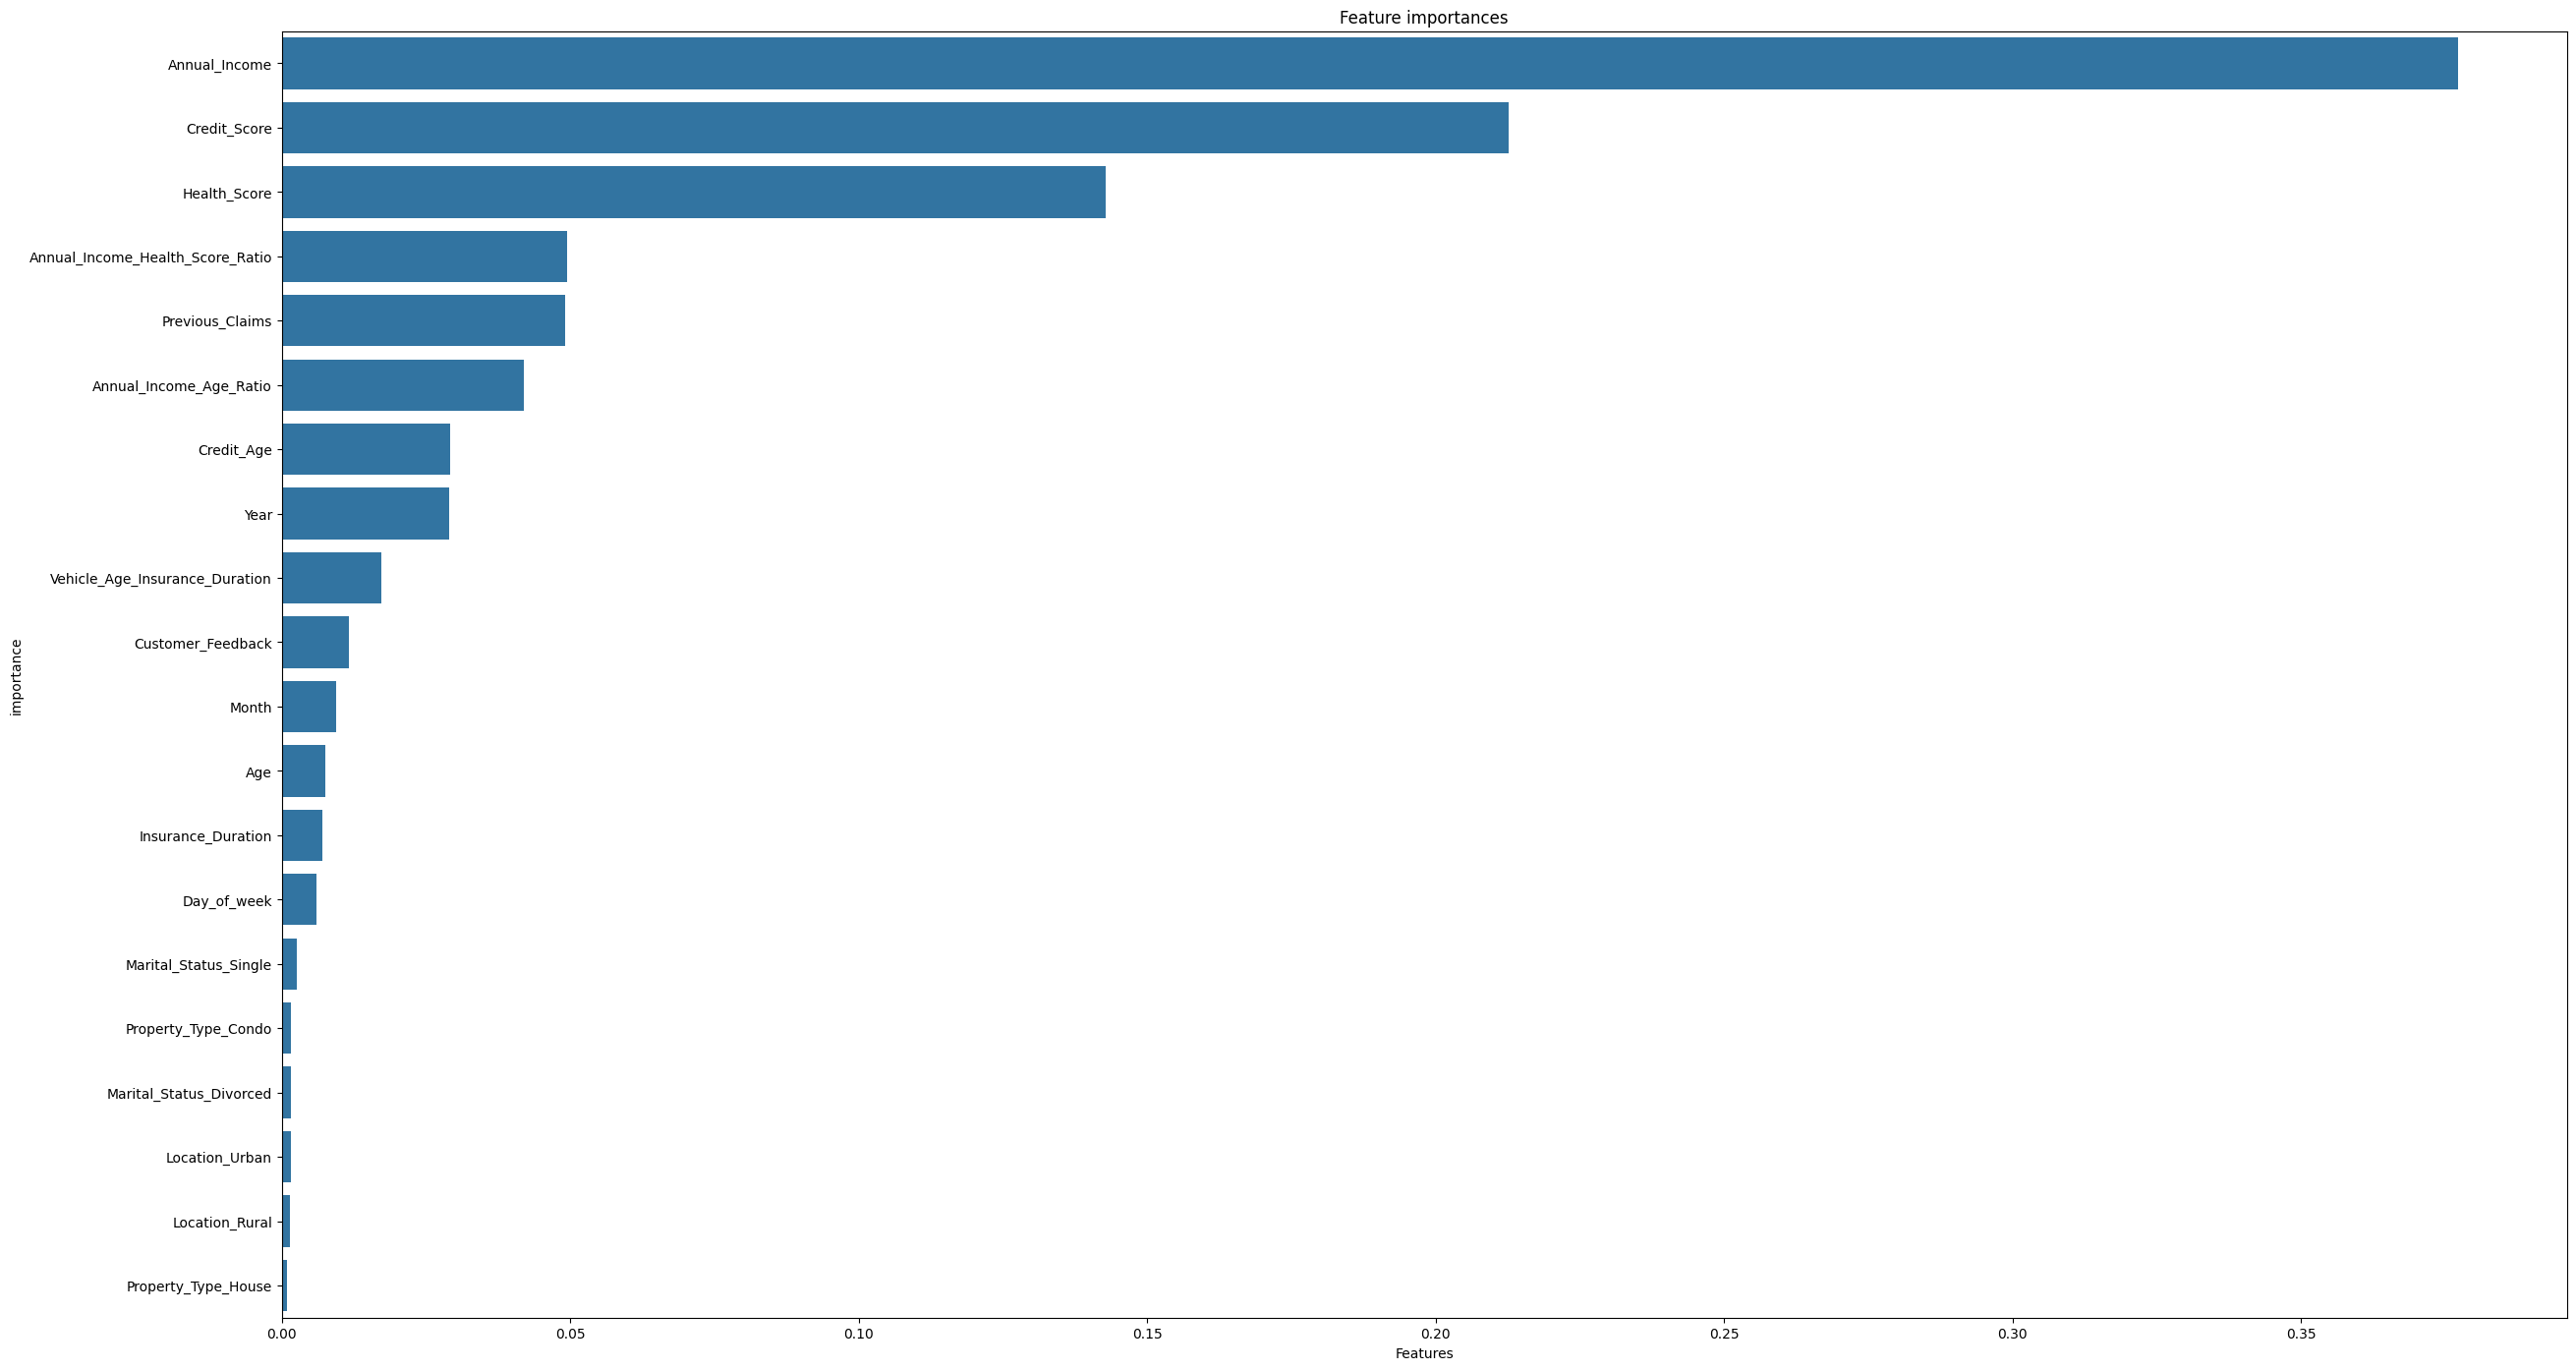

In [44]:
# Визуализация вклада каждого признака модели градиентного бустинга в обучение
fig, ax = plt.subplots(figsize=(30,17))
sns.barplot(
    data = feature_importances_df,
    x = 'importance',
    y = 'feature'
)
ax.set_title('Feature importances')
ax.set_xlabel('Features')
ax.set_ylabel('importance');

In [45]:
# Вывод информации о тренировочном наборе данных 
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 37 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Age                               800000 non-null  float64
 1   Gender                            800000 non-null  int32  
 2   Annual_Income                     800000 non-null  float64
 3   Number_of_Dependents              800000 non-null  float64
 4   Education_Level                   800000 non-null  int32  
 5   Health_Score                      800000 non-null  float64
 6   Previous_Claims                   800000 non-null  float64
 7   Vehicle_Age                       800000 non-null  float64
 8   Credit_Score                      800000 non-null  float64
 9   Insurance_Duration                800000 non-null  float64
 10  Customer_Feedback                 800000 non-null  int32  
 11  Smoking_Status                    800000 non-null  i

In [46]:
# Преобразование тренировочной матрицы наблюдения с учетом лучших признаков
X_test = test_df[['Age', 'Annual_Income', 'Health_Score', 'Previous_Claims',
       'Credit_Score', 'Insurance_Duration', 'Customer_Feedback', 'Year',
       'Month', 'Day_of_week', 'Annual_Income_Health_Score_Ratio',
       'Annual_Income_Age_Ratio', 'Credit_Age',
       'Vehicle_Age_Insurance_Duration', 'Marital_Status_Divorced',
       'Marital_Status_Single', 'Location_Rural', 'Location_Urban',
       'Property_Type_Condo', 'Property_Type_House']]
X_test_scaled = scaler.transform(X_test)
print('Shape of test_data: {}'.format(X_test.shape))

Shape of test_data: (800000, 20)


In [47]:
# Сохранение идентификаторов страхователей в отдельную переменную
test_id = pd.read_csv('test.csv')
test_id = test_id['id']

In [48]:
# Предсказание суммы страховой премии для каждого страхователя из тренировочного набора данных
y_test_predict = gb.predict(X_test_scaled)
y_test_predict = np.exp(y_test_predict) - 1
submission = pd.DataFrame({'id': test_id, 'Premium_Amount': y_test_predict})

submission.head(10)

,id,Premium_Amount
0,1200000,750.967192
1,1200001,505.605824
2,1200002,789.470274
3,1200003,710.663021
4,1200004,778.005948
5,1200005,751.243999
6,1200006,948.154514
7,1200007,688.761577
8,1200008,247.856693
9,1200009,830.002629


In [49]:
# Подготовка к построению модели экстремального градиентного бустинга
import xgboost as xgb
# Лучшие 20 признаков
best_features = ['Age', 'Annual_Income', 'Health_Score', 'Previous_Claims',
       'Credit_Score', 'Insurance_Duration', 'Customer_Feedback', 'Year',
       'Month', 'Day_of_week', 'Annual_Income_Health_Score_Ratio',
       'Annual_Income_Age_Ratio', 'Credit_Age',
       'Vehicle_Age_Insurance_Duration', 'Marital_Status_Divorced',
       'Marital_Status_Single', 'Location_Rural', 'Location_Urban',
       'Property_Type_Condo', 'Property_Type_House']
# Создание матриц в формате DMatrix
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_log, feature_names=best_features)
dvalid = xgb.DMatrix(X_valid_scaled, label=y_valid_log, feature_names=best_features)
dtest = xgb.DMatrix(X_test_scaled, feature_names=best_features)

In [50]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборки
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучение модели 
model = xgb.train(
    params=xgb_pars,
    dtrain=dtrain,
    num_boost_round=300, 
    evals=watchlist, 
    early_stopping_rounds=20, 
    maximize=False, 
    verbose_eval=10 
)

[0]	train-rmse:1.01342	valid-rmse:1.01344
[10]	train-rmse:0.97958	valid-rmse:0.98030
[20]	train-rmse:0.97308	valid-rmse:0.97424
[30]	train-rmse:0.97066	valid-rmse:0.97239
[40]	train-rmse:0.96938	valid-rmse:0.97178
[50]	train-rmse:0.96839	valid-rmse:0.97147
[60]	train-rmse:0.96758	valid-rmse:0.97141
[70]	train-rmse:0.96693	valid-rmse:0.97136
[80]	train-rmse:0.96628	valid-rmse:0.97134
[90]	train-rmse:0.96564	valid-rmse:0.97132
[100]	train-rmse:0.96498	valid-rmse:0.97127
[110]	train-rmse:0.96437	valid-rmse:0.97132
[119]	train-rmse:0.96382	valid-rmse:0.97133


In [51]:
# Предсказание на тестовом наборе данных
y_test_predict = np.exp(model.predict(dtest)) - 1
print(f'RMSLE score: {np.round(model.best_score, 2)}')

RMSLE score: 0.97


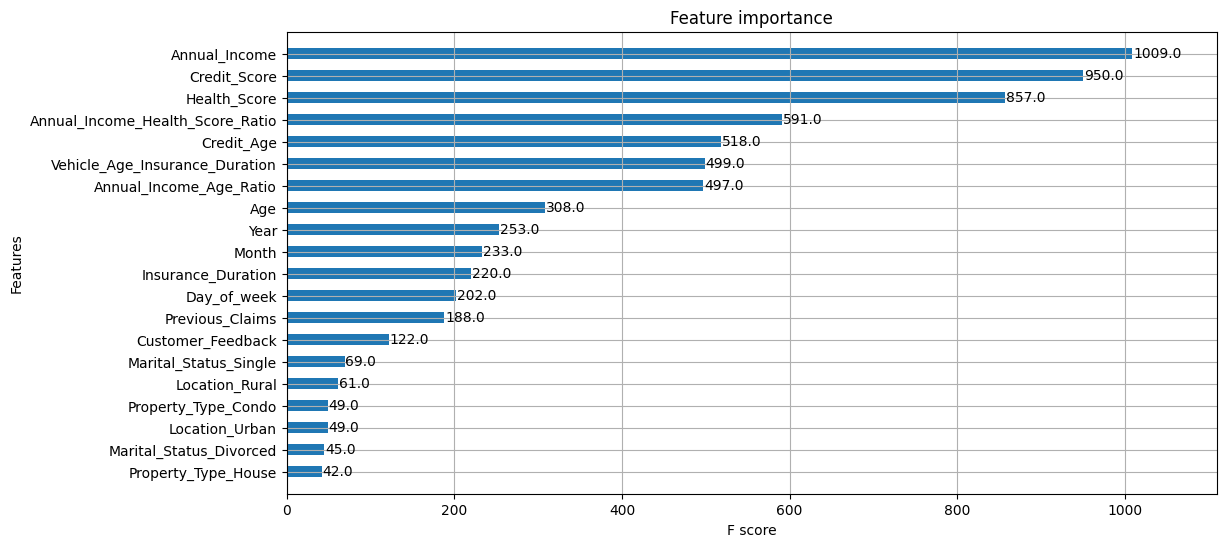

In [52]:
# Визуализация вклада каждого признака модели экстремального градиентного бустинга в обучение
fig, ax = plt.subplots(figsize = (12,6))
xgb.plot_importance(model, ax = ax, height=0.5);

In [53]:
from joblib import dump

# Сохранение моделей
dump(gb, 'gradient_boosting_model.joblib')
model.save_model('xgboost_model.json')